# Regressão Logística (Iris dataset) matricial - visualização durante treinamento

Este notebook é baseado no notebook anterior, porém agora, durante o treinamento, é possível visualizar tanto o comportamento da função de perda como das fronteiras de decisão.

É possível também, interromper o treinamento parando o kernel.

Os comentários do notebook anterior foram retirados para melhor legibilidade do código.

É importante ver como esta implementação é extremamente simples, com pouco código, devido à implementação matricial dos algoritmos.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
from sklearn.datasets import load_iris

In [12]:
def oneHotIt(Y,k):
    Y = Y.reshape(-1,1)
    i = np.arange(k).reshape(1,k)
    Y_oh = (Y == i).astype(int)
    return Y_oh

def softmax(Z):
    # computes softmax for all samples, normalize among classes (columns)
    # input Z: scores; shape: samples rows x classes columns
    # output S: same shape of input
    EZ = np.exp(Z)
    S = EZ / EZ.sum(axis=1,keepdims=True) # normaliza nas classes - colunas
    return S

def predict(X,W):
    S = softmax(X.dot(W))
    # escolhe a maior probabilidade entre as classes
    Y_hat = np.argmax(S,axis=1) # mantém o resultado como matriz bidimensional
    return Y_hat

def getAccuracy(X,W, Y):
    Y_hat = predict(X,W)
    accuracy = sum(Y_hat == Y)/(float(len(Y)))
    return accuracy

In [13]:
iris = load_iris()
X = iris.data[:,::2]  # comprimento das sépalas e pétalas, indices 0 e 2
Xc = X - X.min(axis=0)
Xc /= X.max(axis=0)
X_bias = np.hstack([np.ones((150,1)),Xc]) # incluído X00 como 1 para gerar bias no W
Y = iris.target
Y_oh = oneHotIt(Y,3)


W:
[[ 3.06543176  0.25392255 -3.31935432]
 [-1.91203791 -0.1792111   2.09124901]
 [-8.15755828  1.31201269  6.84554559]]
Final loss: 0.397251394935
Training Accuracy:  0.933333333333


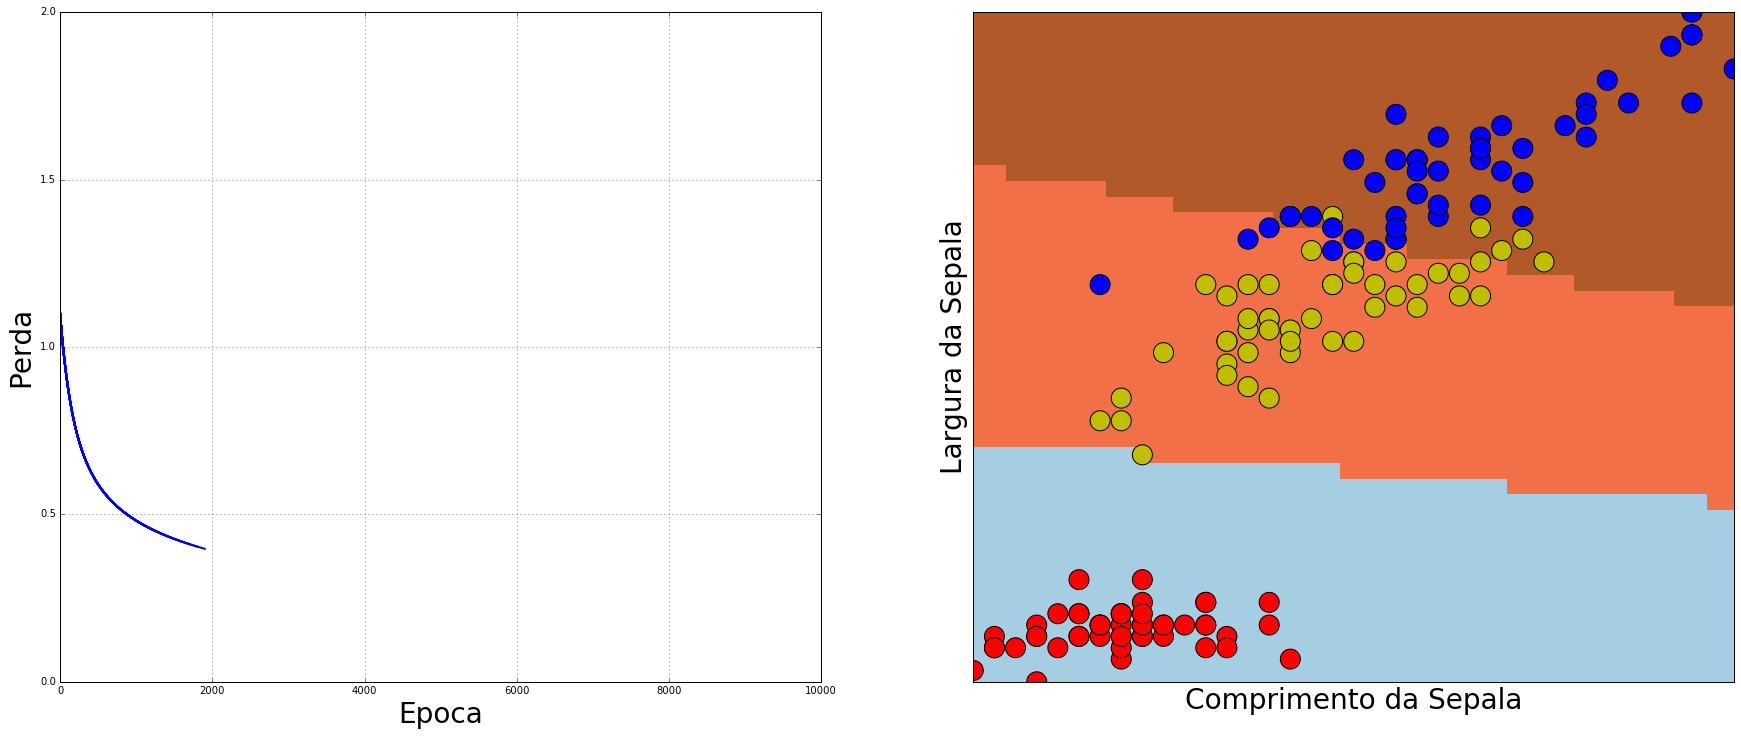

In [14]:
n = X_bias.shape[0] # number of training examples
m = X_bias.shape[1] # number of attributes (features + 1(bias))
k = 3          # number of classes

# Inicialização dos parâmetros
W = np.zeros(shape=(m,k)) # n. de linhas é igual a número de atributos (features, pixels)

iterations = 10000
learningRate = 0.15

#Gráficos a serem mostrados durante o treinamento
ploss = 2.0
fig = plt.figure(figsize=(30,12))
plt.subplot(121)
plt.plot(0.0,ploss)
plt.ylim(0.0, ploss)
plt.xlim(0, iterations)
plt.xlabel('Epoca',fontsize=28)
plt.ylabel('Perda',fontsize=28)
plt.grid(True)
plt.subplot(122)
plt.xlim(X_bias[:,1].min(), X_bias[:,1].max())
plt.ylim(X_bias[:,2].min(), X_bias[:,2].max())
plt.xlabel('Comprimento da Sepala',fontsize=28)
plt.ylabel('Largura da Sepala',fontsize=28)
plt.xticks(())
plt.yticks(())
plot_frequency  = 100
colors = np.array(['r','y','b'])
x_min, x_max = X_bias[:, 1].min() - .5, X_bias[:, 1].max() + .5
y_min, y_max = X_bias[:, 2].min() - .5, X_bias[:, 2].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X_grid = np.c_[xx.ravel(), yy.ravel()]
X_grid = np.hstack([np.ones((X_grid.shape[0],1)),X_grid]) # incluído X00 como 1 para gerar bias no W
losses = []

for i in range(iterations):
  try:
    # Trecho do gradiente descendente
    scores = X_bias.dot(W)
    S = softmax(scores)
    loss = (-1. / n) * np.sum(Y_oh * np.log(S)) 
    Grad = (-1. / n) * (X_bias.T).dot(Y_oh - S) 
    W = W - (learningRate * Grad)
    # Final do trecho do gradiente descendente
    
    losses.append(loss)
    if i%plot_frequency == 0:
        plt.subplot(121)
        plt.plot(np.arange(i+1),losses,'b',linewidth = 2.0)
        plt.subplot(122)
        Z = predict(X_grid, W).reshape(xx.shape)
        plt.figure(1, figsize=(4, 3))
        plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
        plt.scatter(X_bias[:, 1], X_bias[:, 2], s=400, c=colors[Y], edgecolors='k', cmap=plt.cm.Paired)
        display.display(plt.gcf())
        display.clear_output(wait=True)
  except KeyboardInterrupt:
    break

    
print 'W:\n',W
print 'Final loss:',loss
print 'Training Accuracy: ', getAccuracy(X_bias,W,Y)


## Atividades
1. Experimente com diferentes valores de learning rate
2. Troque os atributos por outros dois, por exemplo o primeiro é segundo:
    X = iris.data[:,:2]  # comprimento e largura das sépalas, indices 0 e 1


## Principais aprendizados com este exercício